# Training Deep Neural Networks

Typical problems:
- Gradients grow very small or very large during backprop
- Big neural net needs a lot of data
- Training is very slow
- Overfitting 

## Vanishing/Exploding Gradients Problems

- Gradients often get smaller and smaller as an algorithm gets to lower layers
- For some networks, like RNNs, gradients can explode to big values, causing divergence
- Generally, deep NNs suffer from unstable gradients. Different layers learn at different speeds

When Deep NNs were young, ppl found that sigmoid activation + std normal weight initializing lead to outputs having greater variation than inputs -> this variation stacks over layers.

Sigmoid gradient for extreme values is very close to 0 -> very little left for lower layers

### Glorot Initialization and He Initialization

Need signal to flow in both directions, for forward and backward pass, and not explode/vanish
- For that, need variance of the outputs of each layer to have equal variance to the inputs, and we need to the gradients to have equal variance before and after flowing thru a layer in the reverse direction

To do this, initialize connection weights where $fan_{avg} = (fan_{in} + fan_{out})/2$. Fan_in,out are the input/output numbers.

Using sigmoid:
- Normal distribution, mean 0 and variance $1 / fan_{avg}$
- Uniform distribution btwn -r and r, where r = $\sqrt{3 / fan_{avg}}$

| Initialization | Activation functions | σ² (Normal) |
|----------------|---------------------|-------------|
| Xavier Glorot | None, tanh, sigmoid, softmax | 1 / fan_avg |
| Kaiming He | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish, SwiGLU, ReLU² | 2 / fan_in |
| Yann LeCun | SELU | 1 / fan_in |

- nn.Linear initializes with Kaiming uniform initialization, but scales down by a factor of root 6, and also initializes the biases randomly, which has no benefit.

In [11]:
import torch
import torch.nn as nn

layer = nn.Linear(40,10)
layer.weight.data *= 6**.5 #Kaiming init, or 3**.5 for LeCun
torch.zero_(layer.bias.data)

# this code is equivalent and less error prone

nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [12]:
# If you want to apply this initialization to all linear modules:

def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50,50), nn.ReLU(), nn.Linear(40,1))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
)

There is also 'torch.nn.init.orthogonal_()', which initializes the weights with a random orthogonal matrix. Orthogonal matrices have some useful mathematical properties: given an orthogonal matrix W and input vector x, norm of Wx = norm of x, and that means the magnitude of inputs is preserved in outputs.

Doing this results in stable variance (at least at the start of training). This technique is common for RNNs or GANs.

### Better Activation Functions

- ReLU is better than sigmoid because it doesnt saturate positive values, and its very fast to compute
- However, ReLU "kills" neurons, making some only return 0. This happens when a neuron weights get tweaked in such a way that the weighted sum of inputs + bias is negative for all instances in the training set. This causes a lot of your neurons to be zero in some cases, and gradient descent doesn't affect it anymore.

One fix:

#### Leaky ReLU

$\text{LeakyReLU}_a(z) = max(az, z)$

-hyperparam a defines how much the function leaks, it is the slope of the function for z<0. (a is <1)

-a 2015 paper found that leaky variants always beat ReLU.

- Randomized leaky ReLU is picked randomly during training, fixed during testing, tends to do well and act as regularization
- Parametric leaky ReLU : a is learned during training, gets modified by backpropagation

PReLU strongly beats ReLU on big datasets, but overfits on smaller ones.

In [13]:
nn.LeakyReLU
nn.RReLU
nn.PReLU
# Use these w/ Kaiming initialization
# Scale down variance by (1+a^2) due to negative slope

alpha = .2
model = nn.Sequential(
    nn.Linear(50,40), nn.LeakyReLU(negative_slope=alpha)
)
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")

Parameter containing:
tensor([[-0.1671, -0.1786, -0.1506,  ..., -0.0093,  0.1718,  0.1689],
        [ 0.0085, -0.1873, -0.3000,  ..., -0.0887,  0.0295, -0.2888],
        [ 0.2212, -0.1343, -0.0531,  ..., -0.0652,  0.2004,  0.1407],
        ...,
        [ 0.0630,  0.0610,  0.1615,  ...,  0.2517,  0.2328,  0.1707],
        [-0.0232, -0.3095,  0.0551,  ..., -0.3374,  0.0627,  0.2862],
        [ 0.2013, -0.0475,  0.2104,  ..., -0.2893, -0.2781, -0.1002]],
       requires_grad=True)

Issue with these ReLU variants is that they aren't smooth, sharp cut at 0 which messes with gradients. 

#### ELU and SELU
- Exponential linear unit (ELU): 
    - $\alpha(exp(z)-1)$, if z < 0
    - z, if z >= 0

- Takes on negative values which helps stop vanishing gradients
- Takes alpha, which is a hyperparam that controls lim elu as z->-inf
- If a=1, function is smooth everywhere
- A bit slower than RELU + variants

- Scaled ELU (SELU) :
    - About 1.05*ELU
    - Proven by authors than if you use a neural net composed of a dense layer stack, and use SELU, network will self-normalize
    - Makes SELU good for deep MLP models
    Conditions:
        - Inputs must be standardized
        - Every hidden layer must be initializes w/ LeCun normal initialization
        - Only works w plain MLPS.
        - Cannot use regularization techniques

#### GELU, Swish, SwiGLU, Mish, RELU^2

- Gaussian Error Linear Unit (GELU):
    - Smooth RELU-type function
    - GELU(z) = $z\Phi(z)$
    - Not concave or convex, has curvature at every point
    - In practice, tends to beat previous activations
    - However, it is slower
    - And the approximation $z\sigma(1.702z)$ is faster to compute

- Swish:
    - $\text{Swish}_\beta(z) = z\sigma(\beta z)$
    - B=1.702 is approx equal to GELU
    - Can fit B w/ model

- SwiGLU:
    - Inputs go thru Swish activation and thru a linear layer, and then multiplied itemwise
    - SwiGLU(z) = $\text{Swish}_\beta(z) * \text{Linear}(z)$
    - Very common in modern transformers
    - Itemwise multiplication allows models to learn when to turn off or amplify specific features, called a *gating mechanism*

- Mish:
    - Mish(z) = ztanh(softplus(z))
        - softplus(z) = log(1+exp(z))
    - Overlaps w Swish when z is negative, and GELU when z is positive

- ReLU^2
    - $\text{ReLU}^2 = (max(0,z))^2$
    - Simple, efficient, often outperforms others for sparse models
    - Training can be less stable due to outlier sensititivity and dying ReLUs

How to pick which one to use?
- ReLU good for most tasks
- Swish better for complex tasks
- Mish/SwiGLU may beat Swish but require more computation
- Need low latency, pick a ReLU variant or ReLU^2

In [14]:
# pytorch supports:
nn.GELU
nn.Mish
nn.SiLU # Swish

F = torch.nn.functional
# To implement SwiGLU:
# 1) double previous layers output dim
# z1, z2 = z.chunk(2, dim=-1)
# F.silu(beta*z1)

# To get relu^2
# F.relu(z).square()

# Simplified activations which are faster/more stable:
nn.Hardsigmoid
nn.Hardtanh
nn.Hardswish

torch.nn.modules.activation.Hardswish

### Batch Noralization

initialization and activation functions reduce gradient issues at the start of training, but they can come back

- Batch Normalization: 
    - add an operation just before/after activation for hidden layers that zero-centers and normalizes input
    - Scale and Shift the result w/ two new parameter vectors per layer

This lets the model learn the optimal scale and mean for each layer's input

If you add a BN layer at the start of the neural net, you wont need a StandardScaler

**The Algorithm:**

*Step 1: Calculate the mean across the mini-batch*

$$\mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} x^{(i)}$$

*Step 2: Calculate the variance across the mini-batch*

$$\sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (x^{(i)} - \mu_B)^2$$

*Step 3: Normalize the inputs*

$$\hat{x}^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

*Step 4: Scale and shift*

$$z^{(i)} = \gamma \odot \hat{x}^{(i)} + \beta$$


- $\mu_B$: vector of input means over mini-batch $B$
- $m_B$: number of instances in the mini-batch
- $x^{(i)}$: input vector for instance $i$
- $\sigma_B^2$: vector of input variances over mini-batch $B$
- $\hat{x}^{(i)}$: zero-centered and normalized input for instance $i$
- $\epsilon$: smoothing term (typically $10^{-5}$) to avoid division by zero
- $\gamma$: output scale parameter vector (learnable)
- $\beta$: output shift parameter vector (learnable)
- $\odot$: element-wise multiplication
- $z^{(i)}$: output of the batch normalization operation

Issue: at test time, no way to compute 1 single instances standard deviation. Small batches also have issues. 

Solution: fix the bach norm layer's mean and sd estimates with the data from training. PyTorch will estimate by using moving averages from the training data.

4 parameter vectors learned per layer: $\gamma, \beta, \mu, \sigma^2$. Scale, shift, mean, variance.

Note that mu and sigma only used after training, during training new parameters are calculated per batch.


Batch normalization has very good results, at the cost of a runtime penalty. You can avoid the runtime penalty by fusing the BN layer with the previous layers weights/biases.

- If previous layer computes XW + b,
- BN layer computs $\gamma \odot (XW + b - \mu) / \sigma + \beta$ (ignore smoother e)
- If we replace W and b with:
    - $W' = \gamma \odot W / \sigma$
    - $b' = \gamma \odot (b - \mu) / \sigma + \beta $
- Simplify to $XW' + b'$

#### Batch Norm in PyTorch

Just add a nn.BatchNorm1d bfore or after each hidden layer's activation, and specify the number of inputs for each BN layer.

Adding a BN layer as the first layer removes the need to standardize manually.

In [15]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1*28*28),
    nn.Linear(1*28*28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300,100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100,10)
)

In [16]:
# each bn layer has a weight (gamma) and bias (beta)
dict(model[1].named_parameters()).keys()

# the buffers
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

In [17]:
# if you want the batch norms after the activations,
# make sure to get rid of bias terms and the first batchnorm to avoid sandwiching the layer
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

`nn.BatchNorm1d` has a momentum hyperparameter, uses to update the exponential moving averages:

vhat = v * momentum + vhat * (1-momentum)

A good momentum is close to 0

#### Batch norm 1D, 2D, 3D

1d requires flat data [batch size, num features], but 2d/3d can have more dimensions. The benefit of 2d [batch_size, channels, height, width] is that you don't need to nn.Flatten() and it computes mean/variance across both batch dimension (0) and spatial dimensions (2, 3). All pixels in same batch/channel get normalized the same way.

BatchNorm1d can work on batches of sequences, but the PyTorch convention is to do batches of sequences as tensors of shape [batch size, sequence_length, num features]

- For example: particle data
    - 32 100-point trajectories in shape [32, 100, 3]
    - Batchnorm1d expects [batch size, features, length]
    - So you need to change the data via: X.permute(0,2,1)



*Batch normalization is so common for deep neural nets thats its often left out of diagrams, but it struggles with bias and some architectures like RNNs, so its being replaced by layer-norm*

### Layer Normalization

Similar to batch norm, but instead of normalizing by batch, it normalizes by feature dimension.

Advantage: LN can compute stats on the fly, at each tep, independently per instance, and behaves the same way during training and testing.

To create a LayerNorm layer, just tell it the size of the dimension you wish to normalize over.

In [18]:
inputs = torch.randn(32, 3, 100, 200) #random rgb image batch
layer_norm = nn.LayerNorm([100,200])
result = layer_norm(inputs)

In [19]:
# Most vision models normalize over every RGB channel at once:
layer_norm = nn.LayerNorm([3, 100,200])
result = layer_norm(inputs)

### Gradient Clipping

Helps stop gradient explosion by not letting them exceed some threshold

Good for RNNs where batch norm is tricky

Implemented by calling nn.utils.clip_grad_(norm/value) at each iteration during training right after gradients are computed

Must give the function the list of parameters whos gradients need clipping

- clip_grad_norm_() clips each grad vectors norm if it exceeds given max_norm
- clip_grad_value_() clips individual components btwn -clip_value and clip_value


In [20]:
# for epoch in range(n_epochs):
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         y_pred = model(X_batch)
#         loss = loss_fn(y_pred, y_batch)
#         loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         optimizer.zero_grad()

Note: clip_grad_value_() changes the orientation of the gradient, wheras norm keeps orientation. Both work well in practice, you need to decide based on dataset.

## Reusing Pretrained Layers

If you can find a NN that is already trained on a similar task, you can reuse some of the layers near input to speed up training. More similar = keep more layers. Generally, always change the output layer.

First, freeze the reused layers by setting `requires_grad=False`, and then train the new layers.

Then try unfreezing one or two hidden layers and use a low learning rate to fine-tune.

If you cant get a good performance, drop the top hidden layers and freeze all the reused ones again, and try again. Iterate thru this process until you find the right number of hidden layers to keep.

### Transfer Learning with PyTorch

First, a model to recognize images from MNIST for all classes besides pullover and tshirt/top.

In [21]:
import torchvision
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader, Subset
import torch

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])
train_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor
)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor
)

label_map = {1:0, 3:1, 4:2, 5:3, 6:4, 7:5, 8:6, 9:7}

train_data.targets = torch.tensor([label_map.get(label.item(), -1) for label in train_data.targets])
test_data.targets = torch.tensor([label_map.get(label.item(), -1) for label in test_data.targets])

train_idxs = [i for i, label in enumerate(train_data.targets) if label != -1]
test_idxs = [i for i, label in enumerate(test_data.targets) if label != -1]

train_data_subset = Subset(train_data, train_idxs)
test_data_subset = Subset(test_data, test_idxs)

train_loader = DataLoader(train_data_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_subset, batch_size=32)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 188kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.1MB/s]


In [22]:
model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100), nn.ReLU(),
    nn.Linear(100,100), nn.ReLU(),
    nn.Linear(100,100), nn.ReLU(),
    nn.Linear(100,8)
)

def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0.0
        for inputs, y_batch in train_loader:
            inputs = inputs.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(inputs)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
        print(f"Epoch: {epoch} - Loss: {total_loss/len(train_loader)}")

device = "cuda"
lr = .01
model_A.to(device)
optimizer = torch.optim.SGD(model_A.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train(model_A, optimizer, xentropy, train_loader, 10)

Epoch: 0 - Loss: 1.2268213999668758
Epoch: 1 - Loss: 0.4603230013350646
Epoch: 2 - Loss: 0.3522301026682059
Epoch: 3 - Loss: 0.3167825600554546
Epoch: 4 - Loss: 0.293016096179684
Epoch: 5 - Loss: 0.27728585355728863
Epoch: 6 - Loss: 0.2625960569952925
Epoch: 7 - Loss: 0.25051315380136174
Epoch: 8 - Loss: 0.2404136303352813
Epoch: 9 - Loss: 0.23005489924053352


In [23]:
model_A.eval()
X_new, y_new = next(iter(test_loader))
X_new = X_new.to(device)
y_new = y_new.to(device)
with torch.no_grad():
    y_pred_logits = model_A(X_new)

y_pred = y_pred_logits.argmax(dim=1)
sum(y_pred == y_new) / len(y_new)

tensor(0.9688, device='cuda:0')

The model trained to recognize everything but pullovers and t-shirts gets about 93% test accuracy 

Lets steal some layers to make a model that classifies between tshirt/top and pullover:

In [24]:
import copy
reused_layers = copy.deepcopy(model_A[:-1]) # everything but output layer
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100,1)
).to(device)

In [25]:
# Freeze the copied layers:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

In [26]:
# And then train the new model:
model_B_on_A.to(device)
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=lr)
xentropy = nn.BCEWithLogitsLoss()
# train(model_A, optimizer, xentropy, # need new data, 10)

General process: train for a few epochs to get good output layer gradients, then unfreeze the reused layers, reduce the learning rate, and keep training.

This process does not work well for small, dense networks, but it does with Transformers and deep CNNs

### Unsupervised Pretraining

You dont have much labeled data nor a model trained a similar task.

Train an unsupervised model, like an autoencoder, and reuse its layers for your lower layers.

Geoffrey Hinton used this technique in 2010 to revive neural nets, but with boltzmann machines as the unsupervised model.

Today, use autoencoder or diffusion model to do the unsupervised part.

### Pretraining on an Auxiliary Task

If you have very little labeled training data, you can train a different neural net on a similar task that does have labeled data.

Example: face recognition. You may not be able to do it with only a few hundred images, but if you first train a model to tell if two images are of the same face, maybe you can.

For NLP applications, you can download text data and generate labeled data by blanking out some words and asking the model to predict what should be there

## Faster Optimizers

Many optimizers are better than (stochastic) gradient descent 

### Momentum

Idea: bowling ball rolling down a hill and picking up speed

Gradient descent takes small steps on smooth slopes and big steps on steep slopes, but never changes speed.

Gradient descent does not care about what the earlier gradients were, just updates weights based on the current gradient of the cost function.

Momentum optimization subtracts local gradient from momentum vector * learning rate (eta), and updates weights by adding this vector.

Whereas gradient descent is a "speed", momentum optimization is an "acceleration"

Friction mechanism: Beta, the momentum coefficient (0 - high friction, 1 - no friction), typical is .9

**Algorithm**
1) $ m = \beta m - \eta \nabla_{\theta}J(\theta) $
2) $ \theta = theta + m $

- if beta=.9, gradients constant, terminal velocity = 10 * gradient * learning rate
- this means momentum is going "down" 10x faster than gradient descent

Due to momentum, the optimizer might overshoot the global minimum, which is why having friction is a good idea.

In [27]:
optimizer = torch.optim.SGD(model.parameters(), momentum=.9, lr=.05)

### Nesterov Accelerated Gradient

A variant of momentum, which is almost always faster

Measures gradient of the cost function not at local position Theta, but slightly ahead in the direction of the momentum, at $\theta + \beta m$

**Algorithm**
1) $ m = \beta m - \eta \nabla_{\theta}J(\theta + \beta m) $
2) $ \theta = theta + m $

Why this works: if momentum pushes theta across a valley, itll just keep going with the weight update. NAG will go across the valley, and before updating, realize that the bottom is behind it instead of ahead of it.

In [28]:
optimizer = torch.optim.SGD(model.parameters(), momentum=.9, nesterov=True, lr=.05)

### AdaGrad
Scales down the gradient vector along the steepest dimensions to correct more towards the global optimum

**Algorithm**
1) $ s = s + \nabla_{\theta}J(\theta) \odot \nabla_{\theta}J(\theta)$
2) $\theta = \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s+\epsilon}$

Step 1 gets the square of the gradients into s, so each s_i is an accumulation of the gradients at parameter theta_i. 

Step 2 is gradient descent but the gradient vector is element-wise divided by root(s+e), where e is a smoothing term set to some very small positive number.

Helps the gradients go directly to the global optimum: 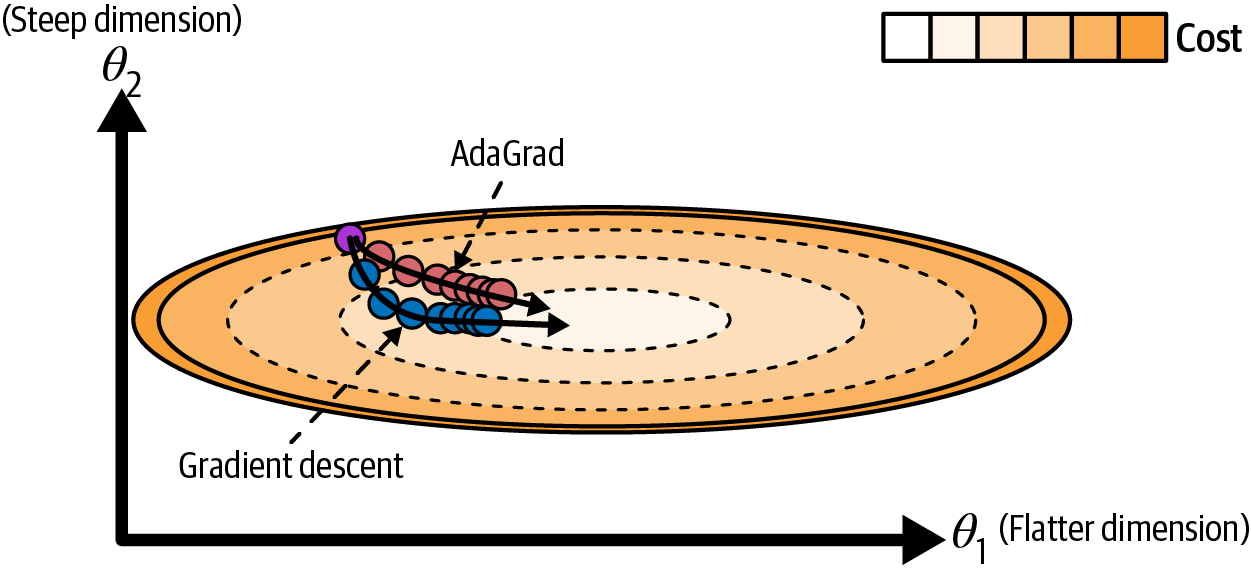

Unfortunately while AdaGrad does well for simple problems, it stops too early for neural nets because the learning rate gets scaled down to 0 too quickly

### RMSProp

Fixes Adagrads issue of slowing too fast by only accumulating gradients from recent iterations

**Algorithm**
1) $ s = \alpha s + (1-\alpha)\nabla_{\theta}J(\theta) \odot \nabla_{\theta}J(\theta)$
2) $\theta = \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s+\epsilon}$

Where alpha is the decay rate, default is .9 and is pretty good

In [29]:
optimizer = torch.optim.RMSprop(model.parameters(), alpha=.9, lr=.05)

### Adam
Adaptive moment estimation

Combines momentum and RMSProp by keeping an exponentially decaying avg of past gradients, and an exponentially decaying avg of past SQUARED gradients

These estimations are moments -> the first and second moments 

**Algorithm**
1) $ m = \beta_1 m - (1-\beta_1)\nabla_{\theta}J(\theta)$
2) $ s = \beta_2 s + (1-\beta_2)\nabla_{\theta}J(\theta) \odot \nabla_{\theta}J(\theta)$
3) $\hat m = \frac{m}{1-(\beta_1)^t}$
4) $\hat s = \frac{s}{1-(\beta_2)^t}$
5) $\theta = \theta + \eta \hat m \oslash \sqrt{\hat s + \epsilon}$

- t represents the iteration number starting at 1
- step 1 is like momentum, 2 is like rmsprop
- since m and s are initialized to 0, steps 3-4 help boost them at the start
- beta_1 usually initialized to .9 (friction, momentum decay)
- beta_2 usually initialized to .999 (scaling decay)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), betas=(.9, .999), lr=.05)
# often default eta .001 is good

### AdaMax
An Adam variant

Notice that Adam accumulates squares of gradients in s, and then in step 5 scales down by root s -> this is equivalent to scaling down the parameter updates by the l2 norm of time-decayed gradients

AdaMax replaces l2 norm with linf norm (max)

Step 2 of Adam is now:
$ s = max(\beta_2 s, abs[\nabla_{\theta}J(\theta)])$

Drops step 4, and in step 5 is scales down gradient updates by s.

In general: more stable, but Adam tends to beat it on performance.

### NAdam

Adam optimization + the nesterov acceleration trick

According to the author, generally beats Adam, sometimes loses to RMSProp

### AdamW

An Adam variant that includes weight decay as regularization.

Reduces the size of the model's weights at each training iteration by multiplying them by some decay factor like .99. Seems similar to l2 regularization, but is a little different.

You should tune the weight_decay hyperparameter

In [31]:
torch.optim.Adam
torch.optim.Adamax
torch.optim.NAdam
torch.optim.AdamW

torch.optim.adamw.AdamW

All of these optimization techniques use first order partial derivatives (Jacobians, measure slope of loss along each axis), but there also exist techniques based on second order partial derivatives (Hessians, which are deriv's of Jacobians, measure loss function curvature)

Hessian algorithms have n^2 derivatives per output, where n is number of parameters, so computing the algorithm is usually too slow.

You can also use stochastic methods to approximate 2nd order info, like "Shampoo" algorithm, which accumulates gradient info to approximate. its in torch_optimizer library


Need fast model -> use sparsity, none of these algos give sparse output. Train model, get rid of small weights with `torch.nn.utils.prune.ln_structured()`

Use l1 regularization to push weights to 0

| **Class** | **Convergence Speed** | **Convergence Quality** |
|-----------|----------------------|-------------------------|
| `SGD` | ★ | ★★★ |
| `SGD(momentum=...)` | ★★ | ★★★ |
| `SGD(momentum=..., nesterov=True)` | ★★ | ★★★ |
| `Adagrad` | ★★★ | ★ (stops too early) |
| `RMSprop` | ★★★ | ★★ / ★★★ |
| `Adam` | ★★★ | ★★ / ★★★ |
| `AdaMax` | ★★★ | ★★ / ★★★ |
| `NAdam` | ★★★ | ★★ / ★★★ |
| `AdamW` | ★★★ | ★★ / ★★★ |

## Learning Rate Scheduling

Ideally you want it to be high at the start to get to the general area of the global minimum and low at the end to fine tune

All these schedulers can be found in `torch.optim.lr_scheduler`

### Exponential Scheduling

Learning rate gets multipled by gamma, usually every epoch, such that lr at epoch i = lr_0 * gamma^i

Want gamma to be close to 1, maybe .9

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)

# In the training loop:
    # for epoch in range(n_epochs):
        # for X_batch, y_batch in train_loader:
        #     [...]  # the rest of the training loop remains unchanged

        # scheduler.step()

### Cosine Annealing
Lets you go from eta_max to eta_min during training, more slowly than exponential. I.e you will have more epochs with a high learning rate

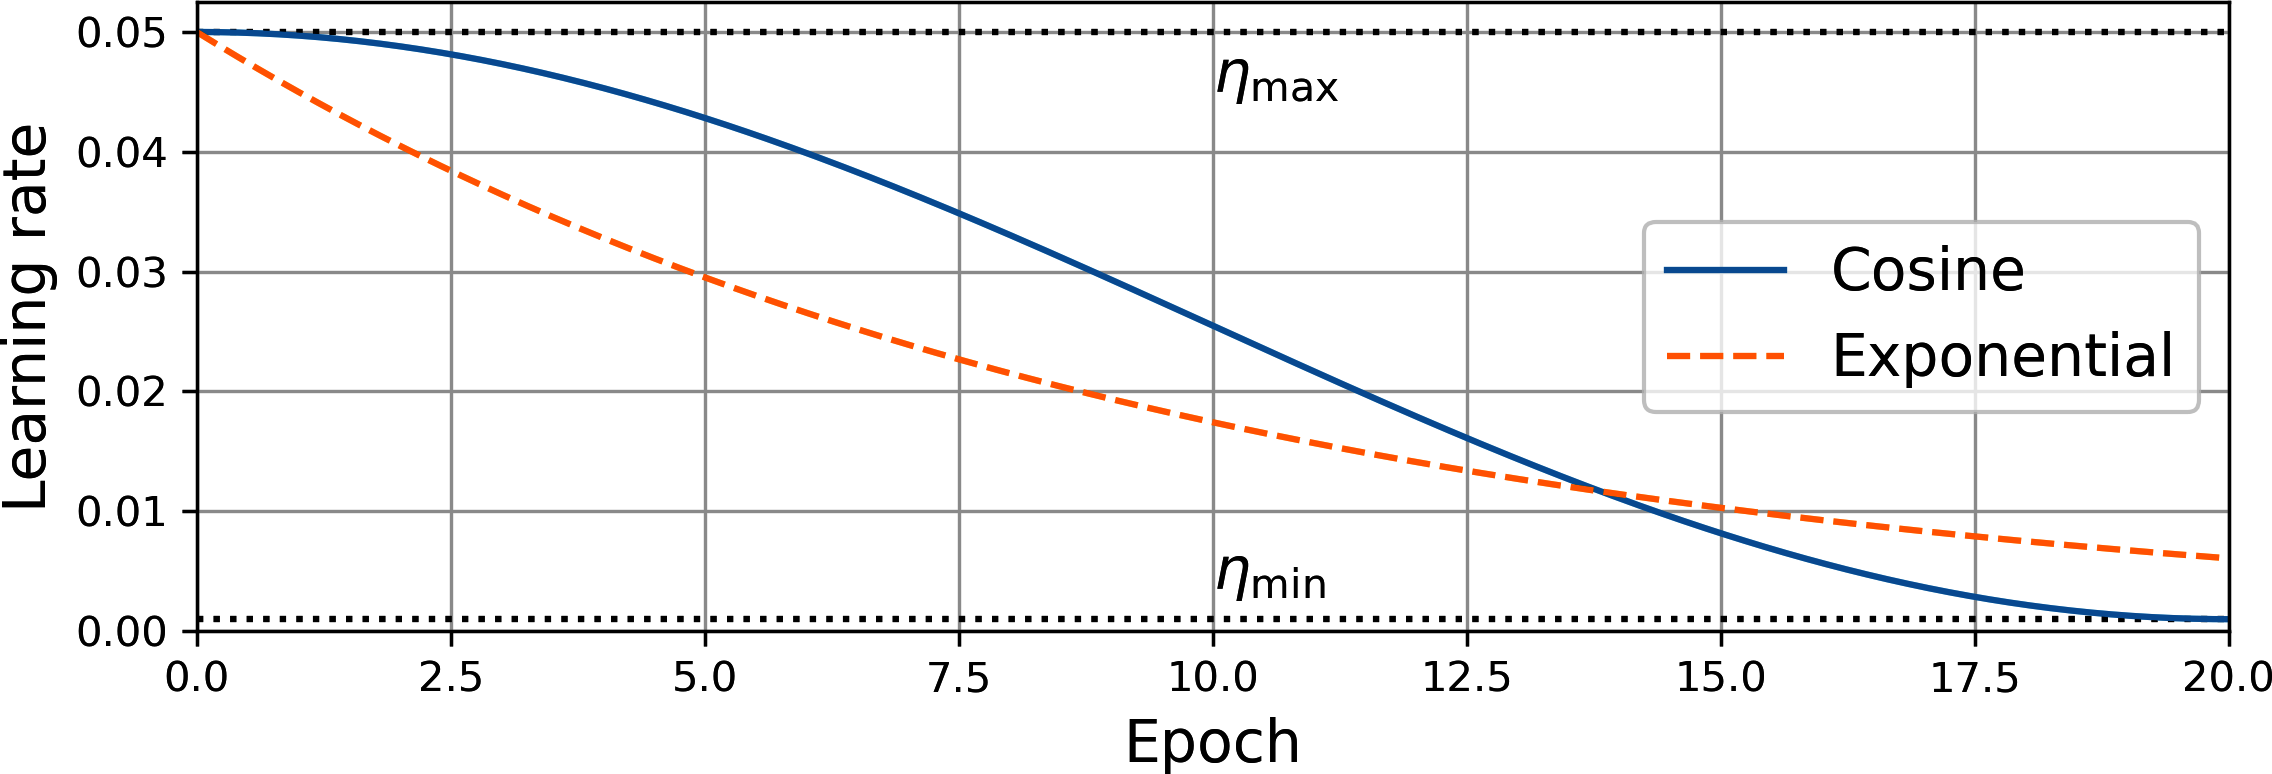

$$ \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + cos(\frac{t \pi}{T_{max}}))

In [34]:
cosine_sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=.001)

### Perfomance Scheduling

(or adaptive scheduling) changes the lr based on model loss (or some other metric). 

Hyperparameters:
- `mode` : whether tracked metric should me minimized or maximized
- `patience` : n epochs to wait for improvement before reducing eta
- `factor` : amount by which lr will be multiplied whenever metric stops improving for awhile

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=.1)

# you need to add an evaluation step in your training loop
# val_metric = evaluate(model, test_loader, nn.CrossEntropyLoss()).item()
# scheduler.step(val_metric)

### Warming up the Learning Rate

Idea: the loss landscape is mountainous, so lets walk from the top of the mountain to the bottom before we start to roll down the valley rather than jumping from mountain top to mountain top.

In PyTorch, you can do this by slowly increasing the learning rate and then using a scheduler to decrease it.

This code goes from .1 -> .4 -> .7 -> 1

In [35]:
warmup_sch = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=.1, end_factor=1, total_iters=3)

In [ ]:
# for more flexibility, use a lambdalr scheduler:
warmup_sch = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda epoch: (min(epoch,3) / 3)*(.9)+.1
)

# at the beginning of each epoch you must insert
warmup_sch.step()

#and add this to the training loop:
# if epoch >= 3:
#     scheduler.step(val_metric)

### Cosine Annealing w/ Warm Restarts

Idea: just repeat cosine anneals over and over so your lr goes up and down and you can escape local mins

Increase t_max after each round so you have longer periods of anneals

T_0 hyperparam is the period of the first cosine anneal

t_mult is how much the t_max gets multiplied each cycle

In [36]:
cosine_repeat_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=2, T_mult=2, eta_min=.001
)

### 1cycle Scheduling

Goes linearly from eta_0 to eta_1 then back to eta_0 during training.

For momentum, usually go like .95 -> .85 -> .95

Was shown to get good performance on some image datasets in a fraction of the epochs a fixed learning rate did

In [37]:
torch.optim.lr_scheduler.OneCycleLR

torch.optim.lr_scheduler.OneCycleLR

Generally, 1cycle and performance scheduling are good ones to default to

If you get stuck on plateaus, consider cosine annealing w/ restarts

## Avoiding Overfitting Through Regularization

Early stopping, batch and layer norm all act as good regularizers

### l1 and l2 Regularization

l1 for sparse model, l2 for constraining weights

l2 optimization = weight decay w/ SGD optimizer

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=.05, weight_decay=.001)

# w/ Adam optimizer, it has weight decay by default
optimizer = torch.optim.AdamW(model.parameters(), lr=.05, weight_decay=.001)

Weight decay is applied to every parameter, even bias terms, and layer/batch norm layers. This doesn't help regularize the model much

Manual l2 regularization:

In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr=.05, weight_decay=.001)
params_to_reg = [
    param for name,param in model.named_parameters()
    if not "bias" in name and not "bn" in name
]
for epoch in range(1):
    for X_batch, y_batch in train_loader:
        # .... rest of loop
        main_loss = loss_fn(y_pred, y_batch)
        l2_loss = sum(param.pow(2.0).sum() for param in params_to_reg)
        loss = main_loss + 1e-4 * l2_loss
        # --- rest of loop

NameError: name 'loss_fn' is not defined

Or use pytorch parameter groups, which lets optimizers apply different hyperparams to different groups of model params

Method:
- pass a list of dicts to optimizer, w/ "params" entry and optional some hyperparam key/val pairs

In [ ]:
params_to_reg = [
    param for name,param in model.named_parameters()
    if not "bias" in name and not "bn" in name
]
params_bias_and_bn = [
    param for name, param in model.named_parameters()
    if "bias" in name or "bn" in name
]
optimizer = torch.optim.SGD(
    [{"params": params_to_reg, "weight_decay":.0001},
     {"params": params_bias_and_bn}],
     lr=.05
)

No pytorch helper for l1 regularization, so you gotta add it manually to the training loop:

In [44]:
main_loss = 0 #whatever ur loss_fn is
l1_loss = sum(param.abs().sum() for param in params_to_reg)
loss = main_loss + .0001 * l1_loss

### Dropout

Very successful regularization technique that helps neural nets a lot

Algorithm:
- At every training step, every neuron (including input neurons, not output neurons) has a probability p of being temporarily ignored during this step

Hyperparameter is the dropout rate p, usually between 10-50%. 20-30 in RNNs, 40-50 in CNNs. No dropping after training.

Basically forces every neuron to be useful, cant rely on a handful of neurons finding signal

You can kind of think of dropout as an ensemble method: 2^N ways to turn every neuron on/off, and you are averaging all those different ways

Higher layers benefit more from dropout because they are the ones learning the complex patterns

**IMPORTANT**: If p=.75%, that means 25% of the neurons are on. After training, your model is spitting out 4x more neuron output. To avoid this, just multiply the inputs by 4 during training, (divide by [1-p])

Just add a Dropout layer during training, and make sure to switch between model.train() and model.eval()

In [46]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=.2), nn.Linear(1*28*28, 100), nn.ReLU(),
    nn.Dropout(p=.2), nn.Linear(100,100), nn.ReLU(),
    nn.Dropout(p=.2), nn.Linear(100,100), nn.ReLU(),
    nn.Dropout(p=.2), nn.Linear(100,10)
).to(device)

See overfitting? increase p

Underfitting? decrease p

Generally, more dropout for big layers, less dropout for small layers

Most SOTA architectures only apply dropout to the last few hidden layers

Keep in mind dropout slows down convergence by a lot, but generalizes way better

### Monte Carlo Dropout

A 2016 paper found some good reasons to use dropout:
- Dropout networks approximate Bayesian inference
- Monte Carlo Dropout, a technique to boost model performance

Idea: keep dropout during evaluation, and make many predictions, and just average the predictions out.

In [64]:
model_A.eval()
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.train()
# this model isnt a dropout model but pretend like it is
X_new.to(device)
with torch.no_grad():
    X_new_repeated = X_new.repeat_interleave(100, dim=0)
    y_logits_all = model_A(X_new_repeated).reshape(32,100,8) # 32 samples, 100 predictions, 8 classes
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    y_probas = y_probas_all.mean(dim=1)

(y_probas.argmax(dim=1) == y_new).sum() / len(y_new)

tensor(0.9688, device='cuda:0')

- Convert model to eval mode, besides the dropout layers
- Move data to device
- Use repeat_interleave() to create a batch containing 100 copies of each image in X_new
    - Images are repeated along first dimension, so new dim is [n*100, 1, 28, 28]
- Pass this batch to model, and change [n*100, 8] shape to [n, 100, 8] to group predictions per image
- Convert logits to probas with softmax
- Compute mean over second dimension to get average estimated prob for each class

MC dropout gives you estimated probabilities and make the model less confidently wrong

You can also calculate standard deviation of class probabilities:
(this is useful if you are working with sensitive predictions, want high estimated proba with low stdev)

In [69]:
y_probas_all.std(dim=1).round(decimals=1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

If you want to train a MC dropout model from scratch, you can use a custom module rather than messing with train() and eval()

In [70]:
class MCDropout(nn.Dropout):
    def forward(self, input):
        return F.dropout(input, self.p, training=True)

### Max-Norm Regularization

For each neuron, constrain weights w of the incoming connections such that $||w||_2 \leq r$, where r is the hyperparam and ||x||_2 is the l2 norm

Lower R = higher regularization

Usually implemented by computing ||w||_2 after each training step and rescaling w if needed:

In [72]:
def apply_max_norm(model, max_norm=2, eps=1e-8, dim=1):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'bias' not in name:
                actual_norm = param.norm(p=2, dim=dim, keepdim=True)
                target_norm = torch.clamp(actual_norm, 0, max_norm)
                param *= target_norm / (eps+actual_norm)

apply_max_norm iterates thru all weight matrices besides biases, and for each one it computes the l2 norm. Linear layer has weights shape [neurons, inputs], so dim=1 gets one norm per neuron. torch.clamp() makes a copy of the actual_norm, but all norms above max norm are replaced by max norm. Then we rescale the weight matrix so each column ends with the target norm.

Just call apply_max_norm(model) in training, right after optimizer.step()

## Practical Guidelines

| **Hyperparameter** | **Default value** |
|--------------------|-------------------|
| Kernel initializer | He initialization |
| Activation function | ReLU if shallow; Swish if deep |
| Normalization | None if shallow; batch-norm or layer-norm if deep |
| Regularization | Early stopping; weight decay if needed |
| Optimizer | Nesterov accelerated gradients or AdamW |
| Learning rate schedule | Performance scheduling or 1cycle |

- use l1 regularization for a sparse model
- use relu (+variants) or hardswish for faster model
- Reduce float precision to 32, 16, or 8 bits
- Use MC dropout if speed doesn't matter